In [1]:
% matplotlib inline

import matplotlib.pyplot as plt
import seaborn
seaborn.set_style('white')

from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [2]:
from glob import glob
import os
import numpy as np

import sys
sys.path.append('scripts')
import load_utils

# Preprocess CT scans for ROI segmentation

In [3]:
! python scripts/prepare_aorta_segmentation.py -h

usage: prepare_aorta_segmentation.py [-h] [--batch-size N] [--j J] [--n N]
                                     idir odir

Preprocess CT scans for ROI segmentation.

positional arguments:
  idir            input directory
  odir            output directory

optional arguments:
  -h, --help      show this help message and exit
  --batch-size N  batch size to load in RAM
  --j J           number of process to run simultaneously
  --n N           maximum number of samples to be processed


In [4]:
! rm -r ../DM_Data/prepared_aorta_training/
! python scripts/prepare_aorta_segmentation.py ../DM_Data/RIII/ ../DM_Data/prepared_aorta_training/ --n=3
! ls ../DM_Data/prepared_aorta_training/

rm: cannot remove '../DM_Data/prepared_aorta_training': No such file or directory
100%|█████████████████████████████████████████████| 4/4 [00:20<00:00,  5.06s/it]
0201R3011  0304R3039  1649R3008


# Train UNet over CT scans for ROI segmentation

In [5]:
! python scripts/train_aorta_segmentation.py -h

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
usage: train_aorta_segmentation.py [-h] [--batch-size N] [--epochs E]
                                   [--split S] [--j J]
                                   idir mdir

Train UNet over CT scans for ROI segmentation.

positional arguments:
  idir            input directory
  mdir            output model directory

optional arguments:
  -h, --help      show this help message and exit
  --batch-size N  batch size to load in RAM
  --epochs E      number of epochs
  --split S       train / test split: train = patient_ids[int(SPLIT *
                  len(patient_ids)):]
  --j J           number of process to run simultaneously


In [7]:
! rm -r ../DM_Data/aorta_model/
! python scripts/train_aorta_segmentation.py ../DM_Data/prepared_aorta_training/ ../DM_Data/aorta_model/ --epochs=3

rm: cannot remove '../DM_Data/aorta_model/': No such file or directory
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Epoch 1/1
2018-02-21 14:25:17.396480: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2018-02-21 14:25:17.484133: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:892] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2018-02-21 14:25:17.484487: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1030] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:1e.0
totalMemory: 11.17GiB freeMemory:

# UNet inference over CT scans, ROI segmentation

In [4]:
! python scripts/predict_aorta_segmentation.py -h

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
usage: predict_aorta_segmentation.py [-h] [--spacing S] [--batch-size N]
                                     [--TTA T] [--j J] [--pdir PDIR] [--n N]
                                     idir odir mpath

UNet inference over CT scans, ROI segmentation.

positional arguments:
  idir            input directory
  odir            output directory
  mpath           path to the model

optional arguments:
  -h, --help      show this help message and exit
  --spacing S     if included isotropic spacing of CT will be forced,
                  otherwise original spacing will be preserved
  --batch-size N  batch size to load in RAM
  --TTA T         whether to have test time augmentations, T in {0, 1, 2, 3}
  --j J           number 

In [5]:
! rm -r ../DM_Data/predicted_aorta/
! rm -r ../DM_Data/processed_patient/
! python scripts/predict_aorta_segmentation.py ../DM_Data/RIII ../DM_Data/predicted_aorta ../DM_Data/best_aorta_model/unet_model --pdir=../DM_Data/processed_patient --batch-size=32 --spacing=1.0

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
2018-02-21 15:13:36.071644: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2018-02-21 15:13:36.143334: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:892] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2018-02-21 15:13:36.143683: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1030] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:1e.0
totalMemory: 11.17GiB freeMemory: 11.10GiB
2018-02-21 15:13:36.143722: I tensorflow/core/common_runtime/gpu/gpu_de

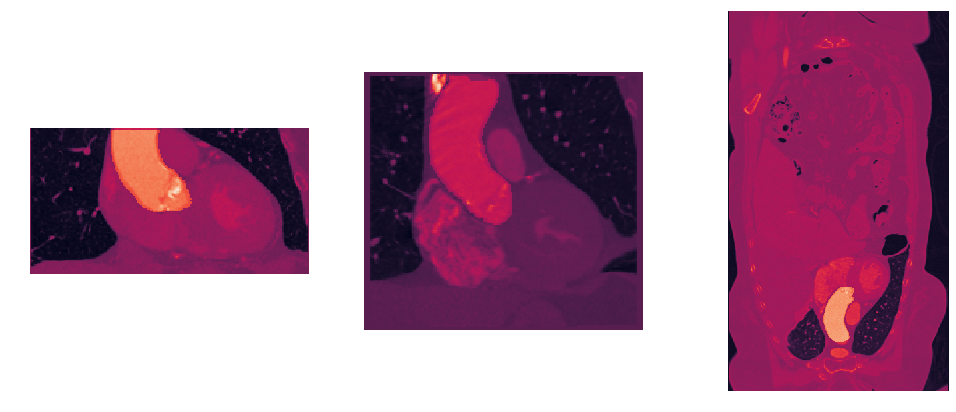

In [6]:
paths = glob('../DM_Data/predicted_aorta/*')
pdir = '../DM_Data/processed_patient'
plt.figure(figsize=(17, 7))

for i in range(3):
    path = np.random.choice(paths)
    mask = np.load(path)
    patch = np.load(os.path.join(pdir, os.path.basename(path)))
    plt.subplot(1, 3, i + 1)
    z, x, y = np.where(mask)
    plt.imshow(patch[:, int(x.mean())] + 750 * mask[:, int(x.mean())])
    plt.axis('off');

# Extract normal planes of CT scans and predicted masks

In [10]:
! python scripts/extract_normals.py -h

usage: extract_normals.py [-h] [--side SIDE] [--j J] [--s S] [--n N]
                          maskdir patdir odir

Extract normal planes of CT scans and predicted masks.

positional arguments:
  maskdir      masks input directory
  patdir       input directory should contains patients' CT scans
  odir         output directory

optional arguments:
  -h, --help   show this help message and exit
  --side SIDE  output directory
  --j J        number of process to run simultaneously
  --s S        Skip first S samples
  --n N        maximum number of samples to be processed


In [8]:
! python scripts/extract_normals.py ../DM_Data/predicted_aorta ../DM_Data/processed_patient ../DM_Data/normals_extracted

Iteration 1/51, patient id: 1006R3036.npy
100%|█████████████████████████████████████████| 165/165 [00:33<00:00,  4.99it/s]
Iteration 2/51, patient id: 0679R3035.npy
100%|█████████████████████████████████████████| 130/130 [02:01<00:00,  1.07it/s]
Iteration 3/51, patient id: 0763R3040.npy
100%|█████████████████████████████████████████| 134/134 [00:37<00:00,  3.62it/s]
Iteration 4/51, patient id: 0763R3031.npy
100%|█████████████████████████████████████████| 125/125 [02:40<00:00,  1.28s/it]
Iteration 5/51, patient id: 0304R3039.npy
100%|█████████████████████████████████████████| 211/211 [02:06<00:00,  1.67it/s]
Iteration 6/51, patient id: 1166R3021.npy
100%|█████████████████████████████████████████| 168/168 [01:38<00:00,  1.71it/s]
Iteration 7/51, patient id: 0841R3031.npy
100%|█████████████████████████████████████████| 252/252 [13:32<00:00,  3.22s/it]
Iteration 8/51, patient id: 1006R3068.npy
100%|█████████████████████████████████████████| 184/184 [00:56<00:00,  3.23it/s]
Iteration 9/51, 

In [12]:
! python scripts/extract_normals.py ../DM_Data/predicted_aorta ../DM_Data/processed_patient ../DM_Data/normals_extracted --s=14

Iteration 1/37, patient id: 0763R3019.npy
100%|█████████████████████████████████████████| 171/171 [01:50<00:00,  1.54it/s]
Iteration 2/37, patient id: 0159R3024.npy
100%|█████████████████████████████████████████| 229/229 [04:03<00:00,  1.06s/it]
Iteration 3/37, patient id: 0123R3062.npy
100%|█████████████████████████████████████████| 201/201 [02:21<00:00,  1.42it/s]
Iteration 4/37, patient id: 1184R3028.npy
100%|█████████████████████████████████████████| 133/133 [01:01<00:00,  2.17it/s]
Iteration 5/37, patient id: 1184R3024.npy
100%|█████████████████████████████████████████| 138/138 [00:57<00:00,  2.41it/s]
Iteration 6/37, patient id: 0127R3004.npy
 20%|████████▌                                 | 30/148 [01:13<04:50,  2.46s/it]^C


# Prepare dataset for valve segmentation (require valve annotated data)

In [132]:
! python scripts/prepare_valve_segmentation.py  -h

usage: prepare_valve_segmentation.py [-h] [--s S] [--n N]
                                     ndir mdir patdir valvecsv odir

Prepare dataset for valve segmentation.

positional arguments:
  ndir        directory should contains prods & slices directories (output
              from extract_normals)
  mdir        directory with valve masks
  patdir      directory with CTs, processed w.r.t. valve masks
  valvecsv    csv file: [seriesuid, idx0, idx1] w.r.t. processed CTs
  odir        output directory

optional arguments:
  -h, --help  show this help message and exit
  --s S       Skip first S samples
  --n N       maximum number of samples to be processed


In [136]:
! python scripts/prepare_valve_segmentation.py  ../DM_Data/normals_extracted ../DM_Data/predicted_aorta ../DM_Data/processed_patient valve.csv ../DM_Data/prepared_valve_training
! ls ../DM_Data/prepared_valve_training

  2%|▉                                        | 6/268 [01:27<1:03:36, 14.57s/it]^C
0201R3009  0261R3002  0862R3150  0939R3004  1006R3002  1006R3058


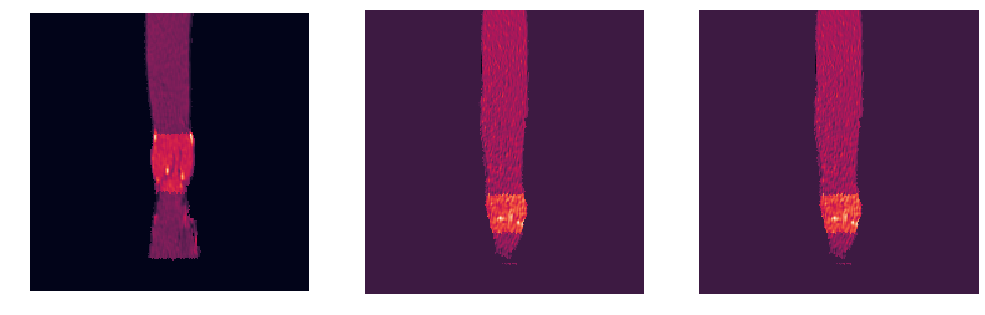

In [137]:
idir = '../DM_Data/prepared_valve_training'
plt.figure(figsize=(17, 7))
for i in range(3):
    path = np.random.choice(glob(os.path.join(idir, '*')))
    mask = np.load(os.path.join(path, 'mask_0.npy'))
    patch = np.load(os.path.join(path, 'patch_0.npy'))
    plt.subplot(1, 3, i + 1)
    plt.imshow(patch + mask)
    plt.axis('off');

# Train valve segmentation model

In [138]:
! python scripts/train_valve_segmentation.py -h

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
usage: train_valve_segmentation.py [-h] [--epochs E] mdir mpath

Train valve segmentation model.

positional arguments:
  mdir        directory with prepared data (should contains mask_*.npy)
  mpath       path to the model

optional arguments:
  -h, --help  show this help message and exit
  --epochs E  maximum number of epochs to be trained


In [140]:
! python scripts/train_valve_segmentation.py ../DM_Data/prepared_valve_training ../DM_Data/valve_model/mvlv --epochs=2

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Epoch 1/2
2018-02-21 18:18:10.343254: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
2018-02-21 18:18:10.472443: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:892] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning 

# Predict valve segmentation

In [141]:
! python scripts/predict_valve_segmentation.py -h

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
usage: predict_valve_segmentation.py [-h] [--n N] [--s S] idir odir mpath

Valve segmentation model inference over prepared dataset

positional arguments:
  idir        directory with prepared data (should contains mask_*.npy)
  odir        output directory
  mpath       path to the model

optional arguments:
  -h, --help  show this help message and exit
  --n N       maximum number of epochs to be trained
  --s S       Skip first S samples


In [145]:
! python scripts/predict_valve_segmentation.py ../DM_Data/prepared_valve_training/ ../DM_Data/predicted_valve/ ../DM_Data/valve_model/xception_valve --n=4

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
2018-02-21 18:21:44.610369: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2018-02-21 18:21:44.696502: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:892] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2018-02-21 18:21:44.696878: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1030] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:1e.0
totalMemory: 11.17GiB freeMemory: 11.10GiB
2018-02-21 18:21:44.696925: I tensorflow/core/common_runtime/gpu/gpu_de

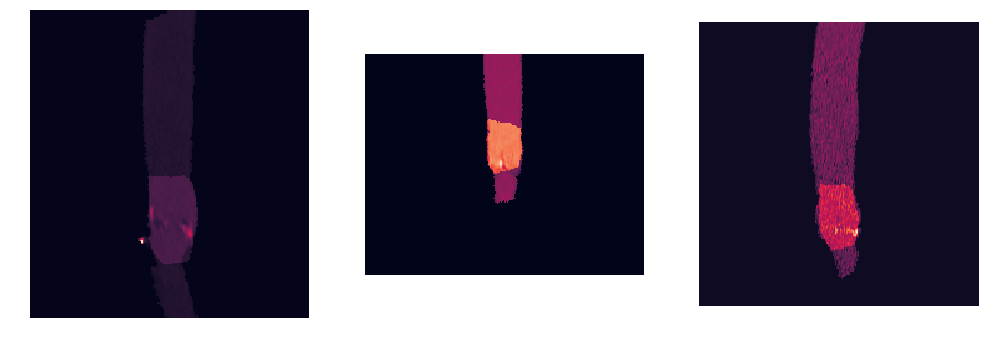

In [147]:
idir = '../DM_Data/predicted_valve/'
mdir = '../DM_Data/prepared_valve_training/'

plt.figure(figsize=(17, 7))
for i in range(3):
    path = np.random.choice(glob(os.path.join(idir, '*')))
    patch = np.load(os.path.join(mdir, os.path.basename(path)[:-4], 'patch_3.npy'))
    predict = np.load(os.path.join(path))
    plt.subplot(1, 3, i + 1)
    plt.imshow(patch[:predict.shape[0], :predict.shape[1]] + predict[:patch.shape[0], :patch.shape[1]])
    plt.axis('off');

# Prepare features

In [148]:
! python scripts/prepare_features.py -h

usage: prepare_features.py [-h] [--labels_path LP] [--exclude_paths EP]
                           [--n N] [--s S]
                           idir zpdir valve_path opath

Prepare features for valve size classification.

positional arguments:
  idir                input directory
  zpdir               directory should contains zis.npy and prods.npy
  valve_path          path to the valve.csv
  opath               output directory

optional arguments:
  -h, --help          show this help message and exit
  --labels_path LP    path to the REPRISE III Sizes.xlsx
  --exclude_paths EP  path to the pickled version of excluded paths
  --n N               maximum number of samples to be processed
  --s S               Skip first S samples


In [ ]:
! python scripts/prepare_features.py ~/edata/ ~/cdata/DM_Data/RIII valve.csv ~/edata/features.csv --labels_path=../DM_Data/REPRISE\ III\ Sizes.xlsx --exclude_paths=exclude_paths --n=3

In [33]:
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
import pandas as pd
from tqdm import tqdm
import pickle


features = pd.read_csv('features')
features = features.drop(['Unnamed: 0'], axis=1)

labels = features[['class']]
for label in labels['class'].unique():
    labels[label] = features['class'] == label
labels = labels.drop(['class'], axis=1).values
features = features.drop(['class', 'seriesuid'], axis=1).values

loo = LeaveOneOut()
predicted = dict()
gt = list()
clfs = [
        GradientBoostingClassifier(n_estimators=3, max_depth=2, random_state=10)
    ]
for clf in clfs:
    predicted[str(clf.__class__)] = list()
    for split, lo in tqdm(loo.split(features)):
        clf.fit(features[split], np.argmax(labels[split], axis=1))

        predicted[str(clf.__class__)].append(clf.predict_proba(features[lo]))
        
for i, clf in enumerate(clfs):
    pred = np.array(predicted[str(clf.__class__)])
    pred = np.argmax(pred, axis=-1)
    gt = np.argmax(labels, axis=-1)
    print((len(labels) - (np.abs(np.squeeze(pred) - gt) > 0).sum()) / len(labels))


pickle.dump(clfs, open('../clfs', 'wb'))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
127it [00:00, 187.52it/s]

0.748031496063
